# Data block foundations

In [ ]:
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
With SwiftPM flags: []
Working in: /tmp/tmpizb4ol4t
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 3.24s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'FastaiNotebook_07_batchnorm' (10 sources)
/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm/Sources/FastaiNotebook_07_batchnorm/07_batchnorm.swift:50:15: warning: typealias overriding associated type 'Input' from protocol 'Layer' is better expressed as same-type constraint on the protocol
    typealias Input = Tensor<Scalar>
    ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~
    
TensorFlow.Layer:2:20: n

In [ ]:
import FastaiNotebook_07_batchnorm
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
// export
import Path
import TensorFlow
import Python

In [ ]:
let plt = Python.import("matplotlib.pyplot")

## Image ItemList

### Download Imagenette

In [ ]:
//export
let dataPath = Path.home/".fastai"/"data"

In [ ]:
//export
func downloadImagette(path: Path = dataPath) -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
    let fname = "imagenette-160"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = shellCommand("/bin/tar", ["-xzf", (path/"\(fname).tgz").string, "-C", path.string])
    }
    return file
}

In [ ]:
let path = downloadImagette()

In [ ]:
print(path.ls())

[Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/train)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/models))]


To be able to look at what's inside a directory from a notebook, we add the `.ls` method to `Path` with a monkey-patch.

In [ ]:
print((path/"val").ls())

[Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03888257)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03445777)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03425413)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n01440764)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03028079)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n02979186)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n03394916)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160/val/n02102040)), Path.Entry(kind: Path.Entry.Kind.directory, path: Path(/home/ubuntu/.fastai/data/imagenette-160

Let's have a look inside a class folder (the first class is tench):

In [ ]:
let pathTench = path/"val"/"n01440764"

In [ ]:
let imgFn = pathTench.ls()[0].path
imgFn.string

"/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017995.JPEG"


In [ ]:
let imgBytes = Raw.readFile(filename: StringTensor(imgFn.string))
let decodedImg = Raw.decodeJpeg(contents: imgBytes, channels: 3, dctMethod: "") 

In [ ]:
print(type(of: decodedImg))

Tensor<UInt8>


In [ ]:
let np = Python.import("numpy")

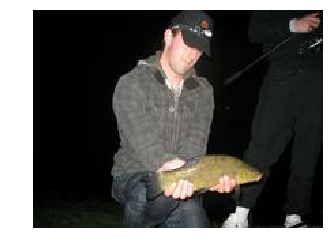

None


In [ ]:
let numpyImg = decodedImg.makeNumpyArray()
plt.imshow(numpyImg) 
plt.axis("off")
plt.show()

In [ ]:
//export
public func fetchFiles(path: Path, recurse: Bool = false, extensions: [String]? = nil) -> [Path]{
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += fetchFiles(path: p.path, recurse: recurse, extensions: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased) {
            res.append(p.path)
        }
    }
    return res
}

In [ ]:
time() { let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"]) }

1121.092664 ms


In [ ]:
let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"])

In [ ]:
fNames.count == 13394

true


## Prepare the data

`Dataset` can handle all the transforms that go on a `Tensor`, including opening an image and resizing it since it takes `StringTensor`. We just prepare the data by splitting and labeling.

### Split

In [ ]:
// export
public struct SplitData<Item>{
    public let train: [Item]
    public let valid: [Item]
    
    public init(train: [Item], valid: [Item]){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(items: [Item], fromFunc: (Item) -> Bool){
        var (trn, val): ([Item], [Item]) = ([], [])
        for x in items {
            if fromFunc(x) { val.append(x) }
            else           { trn.append(x) }
        }
        (self.train, self.valid) = (trn, val)
    }
}

In [ ]:
// export
public func grandParentSplitter(fName: Path, valid: String = "valid") -> Bool{
    return fName.parent.parent.basename() == valid
}

In [ ]:
let sd = SplitData(items: fNames, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})

### Processor

In [ ]:
// export
protocol Processor {
    associatedtype Input
    associatedtype Output
    
    mutating func initState(items: [Input])
    func process1(item: Input) -> Output
    func deprocess1(item: Output) -> Input
}

In [ ]:
// export
extension Processor {
    func process(items: [Input]) -> [Output]{
        return items.map(){process1(item: $0)}
    }
    
    func deprocess(items: [Output]) -> [Input]{
        return items.map(){deprocess1(item: $0)}
    }
}

In [ ]:
// export
public struct CategoryProcessor: Processor {
    public typealias Input = String
    public typealias Output = Int32
    public var vocab: [Input]? = nil
    public var reverseMap: [Input: Output]? = nil
    
    public mutating func initState(items: [Input]){
        vocab = Array(Set(items)).sorted()
        reverseMap = [:]
        for (i,x) in vocab!.enumerated(){ reverseMap![x] = Output(i) }
    }
    
    public func process1  (item: Input)  -> Output { return reverseMap![item]! }
    public func deprocess1(item: Output) -> Input  { return vocab![Int(item)] }
}

### Label

In [ ]:
//export
public struct SplitLabelData<Item,Label>{
    public let train: ([Item], [Label])
    public let valid: ([Item], [Label])
    
    public init(train: ([Item], [Label]), valid: ([Item], [Label])){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(splitData: SplitData<Item>, labelWith: (Item) -> (Label)){
        train = (splitData.train, splitData.train.map { labelWith($0) })
        valid = (splitData.valid, splitData.valid.map { labelWith($0) })
    }
}

In [ ]:
//export
public func labelWithParent(_ fName: Path) -> String { return fName.parent.basename() }

In [ ]:
let ld = SplitLabelData(splitData: sd, labelWith: labelWithParent)

### Processed labels

In [ ]:
//TODO: figure out the generics to put this in a function
var proc = CategoryProcessor()
proc.initState(items: ld.train.1)
let ld1 = SplitLabelData(train: (ld.train.0, proc.process(items: ld.train.1)),
                         valid: (ld.valid.0, proc.process(items: ld.valid.1)))

In [ ]:
print(proc.vocab!)

["n01440764", "n02102040", "n02979186", "n03000684", "n03028079", "n03394916", "n03417042", "n03425413", "n03445777", "n03888257"]


In [ ]:
print(proc.reverseMap!)

["n02102040": 1, "n03417042": 6, "n03394916": 5, "n03028079": 4, "n03888257": 9, "n03425413": 7, "n03000684": 3, "n03445777": 8, "n01440764": 0, "n02979186": 2]


In [ ]:
print((ld1.train.0[0],ld1.train.1[0]))

(Path(/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_9403.JPEG), 9)


### Datasets

Unfinished, need to polish

In [ ]:
struct LabeledElement: TensorGroup {
    let fnames: StringTensor
    let labels: Tensor<Int32>
}

It's easy to create a dataset!

In [ ]:
let trainDs: Dataset<LabeledElement> = Dataset(elements: LabeledElement(
    fnames: StringTensor(ld1.train.0.map{ $0.string }), 
    labels: Tensor<Int32>(ld1.train.1)))

Now let's add function. For the filenames we'll use this:

In [ ]:
func openAndResize(fname: StringTensor, size: Int) -> Tensor<Float>{
    let imgBytes = Raw.readFile(filename: fname)
    let decodedImg = Raw.decodeJpeg(contents: imgBytes, channels: 3, dctMethod: "")
    let resizedImg = Raw.resizeBicubic(
        images: Tensor<UInt8>([decodedImg]), 
        size: Tensor<Int32>([Int32(size), Int32(size)]))
    return resizedImg.reshaped(to: TensorShape(Int32(size), Int32(size), 3))
}

In [ ]:
let myresize = {openAndResize(fname: $0, size: 128)}

In [ ]:
var trainDs: Dataset<DataBatch<Tensor<Float>, Tensor<Int32>>> = Dataset<LabeledElement>(elements: LabeledElement(
    fnames: StringTensor(ld1.train.0.map{ $0.string }), 
    labels: Tensor<Int32>(ld1.train.1))).map{ DataBatch(
        xb: openAndResize(fname: $0.fnames, size: 128),
        yb: $0.labels)}

In [ ]:
trainDs = trainDs.batched(Int64(64))

In [ ]:
var firstBatch: DataBatch<Tensor<Float>, Tensor<Int32>>? = nil
for batch in trainDs.shuffled() {
    firstBatch = batch
    break
}

In [ ]:
firstBatch!.xb.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 64
    - 1 : 128
    - 2 : 128
    - 3 : 3


Processing image 0
Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6
Processing image 7
Processing image 8


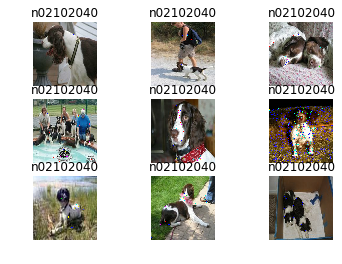

None


In [ ]:
let (rows,cols) = (3,3)
for i in 0..<(rows * cols) {
    print("Processing image \(i)")
    let img = plt.subplot(rows, cols, i + 1)
    img.axis("off")
    let x = firstBatch!.xb[Int32(i)].makeNumpyArray()
    img.imshow(x.astype(np.uint8))
    let title = proc.vocab![Int(firstBatch!.yb[Int32(i)].scalarized())]
    img.set_title(title)
    if (i + 1) >= (rows * cols) { break }
}
plt.show()